Install all the needed imports

In [1]:
%pip install opencv-python tqdm torch torchvision matplotlib pandas scikit-learn

  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
     ---------------------------------------- 78.5/78.5 kB 1.1 MB/s eta 0:00:00
  Using cached torch-2.5.1-cp311-cp311-win_amd64.whl (203.1 MB)
  Using cached torchvision-0.20.1-cp311-cp311-win_amd64.whl (1.6 MB)
     ---------------------------------------- 8.0/8.0 MB 16.5 MB/s eta 0:00:00
     --------------------------------------- 11.6/11.6 MB 22.6 MB/s eta 0:00:00
  Using cached scikit_learn-1.6.0-cp311-cp311-win_amd64.whl (11.1 MB)
  Using cached numpy-2.2.0-cp311-cp311-win_amd64.whl (12.9 MB)
     ---------------------------------------- 1.7/1.7 MB 15.6 MB/s eta 0:00:00
     -------------------------------------- 133.3/133.3 kB 7.7 MB/s eta 0:00:00
  Using cached fsspec-2024.10.0-py3-none-any.whl (179 kB)
  Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
     ---------------------------------------- 2.6/2.6 MB 16.3 MB/s eta 0:00:00
     -------------


[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Extract frames from videos and load them into a PyTorch DataLoader

In [2]:
import os
import cv2
import pandas as pd
from tqdm import tqdm

def extract_frames(video_dir, output_dir, csv_file, frame_rate=1, get_first=True):
    """
    Extracts frames from videos and saves them as .jpg files with names based on ID and frame index.
    
    Args:
        video_dir (str): Directory containing the video files.
        output_dir (str): Directory to save the extracted frames.
        csv_file (str): Path to the CSV file with video IDs and filenames.
        frame_rate (int): Number of frames to extract per second of video.
        get_first (bool): If True, only extract the first frame per video. If False, extract multiple frames.
    """
    video_info = pd.read_csv(csv_file, delimiter=';')

    os.makedirs(output_dir, exist_ok=True)

    for _, row in tqdm(video_info.iterrows(), desc="Extracting frames", total=video_info.shape[0]):
        video_name = row['ID']
        video_file = row['video']
        video_path = os.path.join(video_dir, video_file)

        cap = cv2.VideoCapture(video_path)
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        frame_interval = max(1, fps // frame_rate)
        frame_idx = 0
        extracted = False

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if get_first and not extracted:
                frame_name = os.path.join(output_dir, f"{video_name}.jpg")
                cv2.imwrite(frame_name, frame)
                extracted = True
                break

            if frame_idx % frame_interval == 0:
                frame_name = os.path.join(output_dir, f"{video_name}_{frame_idx}.jpg")
                cv2.imwrite(frame_name, frame)

            frame_idx += 1

        cap.release()
    print(f"Frames extracted and saved to {output_dir}")

if __name__ == "__main__":
    video_dir = "data/visem-dataset/videos"
    output_dir = "data/visem-dataset/frames"
    csv_file = "data/visem-dataset/videos.csv"

    extract_frames(video_dir, output_dir, csv_file, frame_rate=1, get_first=True)

Extracting frames: 100%|██████████| 85/85 [00:00<00:00, 109.58it/s]

Frames extracted and saved to data/visem-dataset/frames


Epoch 1/150, Loss: 294.52586364746094
Epoch 2/150, Loss: 287.3407836914063
Epoch 3/150, Loss: 264.3603454589844
Epoch 4/150, Loss: 232.1687469482422
Epoch 5/150, Loss: 197.6678924560547
Epoch 6/150, Loss: 176.19039001464844
Epoch 7/150, Loss: 152.938720703125
Epoch 8/150, Loss: 174.55745544433594
Epoch 9/150, Loss: 157.50426177978517
Epoch 10/150, Loss: 142.1973876953125
Epoch 11/150, Loss: 191.1492660522461
Epoch 12/150, Loss: 177.32923889160156
Epoch 13/150, Loss: 167.79238586425782
Epoch 14/150, Loss: 145.6272964477539
Epoch 15/150, Loss: 158.02920379638672
Epoch 16/150, Loss: 143.2965087890625
Epoch 17/150, Loss: 155.50970916748048
Epoch 18/150, Loss: 159.35484771728517
Epoch 19/150, Loss: 143.740478515625
Epoch 20/150, Loss: 142.80468292236327
Epoch 21/150, Loss: 138.4090560913086
Epoch 22/150, Loss: 160.8865936279297
Epoch 23/150, Loss: 128.3913146972656
Epoch 24/150, Loss: 143.55198364257814
Epoch 25/150, Loss: 148.6347854614258
Epoch 26/150, Loss: 168.88328399658204
Epoch 27/15

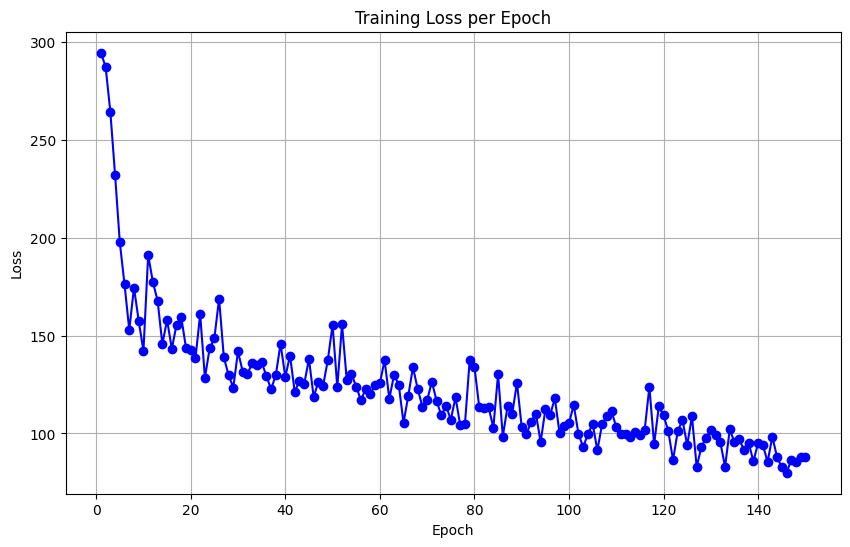

In [3]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

class SpermDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.float32)

image_folder = "data/visem-dataset/frames"
csv_file = "data/visem-dataset/semen_analysis_data.csv"

data = pd.read_csv(csv_file, delimiter=';', decimal=',')

image_ids = data['ID'].values

data['Total sperm count (x10⁶)'] = pd.to_numeric(data['Total sperm count (x10⁶)'], errors='coerce')
# If there are any NaN values after conversion, you can replace them with 0 or the mean of the column
data['Total sperm count (x10⁶)'] = data['Total sperm count (x10⁶)'].fillna(0)

image_paths = [os.path.join(image_folder, f"{img_id}.jpg") for img_id in image_ids]
labels = data['Total sperm count (x10⁶)'].values

X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = SpermDataset(X_train, y_train, transform=transform)
test_dataset = SpermDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class SpermCountingCNN(nn.Module):
    def __init__(self):
        super(SpermCountingCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SpermCountingCNN()

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 150
epoch_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    epoch_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for inputs, targets in test_loader:
        outputs = model(inputs)
        
        y_true.extend(targets.numpy())
        y_pred.extend(outputs.cpu().detach().numpy())
        
y_pred = [np.float32(x[0]) for x in y_pred]
mae = np.mean(np.abs(np.array(y_true) - np.array(y_pred)))
print(f"Test MAE: {mae}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [4]:
print(y_true)
print(y_pred)

[np.float32(354.9), np.float32(363.1), np.float32(695.4), np.float32(18.5), np.float32(136.1), np.float32(478.0), np.float32(129.0), np.float32(69.1), np.float32(158.7), np.float32(807.6), np.float32(353.9), np.float32(170.0), np.float32(141.0), np.float32(535.5), np.float32(824.0), np.float32(345.0), np.float32(415.3)]
[np.float32(420.1086), np.float32(197.58537), np.float32(502.327), np.float32(123.991066), np.float32(260.75165), np.float32(712.17896), np.float32(130.01245), np.float32(202.34578), np.float32(130.26964), np.float32(292.20413), np.float32(177.38457), np.float32(202.72023), np.float32(113.48827), np.float32(318.22708), np.float32(425.2195), np.float32(366.9951), np.float32(176.1231)]


In [12]:
# Save the model
model_path = "experiments/model/sc_cnn_state_dict.pth"
torch.save(model.state_dict(), model_path)

In [8]:
print(X_train)

['data/visem-dataset/frames\\78.jpg', 'data/visem-dataset/frames\\43.jpg', 'data/visem-dataset/frames\\50.jpg', 'data/visem-dataset/frames\\12.jpg', 'data/visem-dataset/frames\\31.jpg', 'data/visem-dataset/frames\\40.jpg', 'data/visem-dataset/frames\\29.jpg', 'data/visem-dataset/frames\\10.jpg', 'data/visem-dataset/frames\\65.jpg', 'data/visem-dataset/frames\\6.jpg', 'data/visem-dataset/frames\\46.jpg', 'data/visem-dataset/frames\\32.jpg', 'data/visem-dataset/frames\\35.jpg', 'data/visem-dataset/frames\\45.jpg', 'data/visem-dataset/frames\\85.jpg', 'data/visem-dataset/frames\\17.jpg', 'data/visem-dataset/frames\\66.jpg', 'data/visem-dataset/frames\\8.jpg', 'data/visem-dataset/frames\\70.jpg', 'data/visem-dataset/frames\\57.jpg', 'data/visem-dataset/frames\\20.jpg', 'data/visem-dataset/frames\\71.jpg', 'data/visem-dataset/frames\\26.jpg', 'data/visem-dataset/frames\\54.jpg', 'data/visem-dataset/frames\\14.jpg', 'data/visem-dataset/frames\\62.jpg', 'data/visem-dataset/frames\\4.jpg', 'da

In [13]:
md = SpermCountingCNN()
md.load_state_dict(torch.load(model_path))
print(md)

SpermCountingCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=131072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


C:\Users\iulia\AppData\Local\Temp\ipykernel_20612\2907620781.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  md.load_state_dict(torch.load(model_path))
